## LABELLING THE DATASET - PART 2

In [ ]:
%pip install transformers vaderSentiment

In [2]:
import pandas as pd
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

c:\Users\Jonathan\Desktop\F20AA - Applied Text Analytics\CW1\F20AA_Grp5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Labelling with RoBERTa based sentiment analysis model

In [2]:
# Read the selected data
selected_data = pd.read_csv('../Data/selected_data.csv')

In [3]:
# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("text-classification", 
                              model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                              device=0) 

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [4]:
# Extract the text column of selected_data as a list
reviews = selected_data["text"].tolist()

In [5]:
# Calculate the sentiment of the each of the reviews
kwargs = {'padding':True,'truncation':True,'max_length':512}
results = sentiment_pipeline(reviews, **kwargs) 

In [6]:
selected_data["roberta_label"] = [res["label"] for res in results]
selected_data["roberta_score"] = [res["score"] for res in results]

### 2. Labelling with VADER (Lexicon and Rule-Based Model)

VADER was selected as it is specialized for sentiment analysis on social media comments.

In [7]:
sentimentAnalyzer = SentimentIntensityAnalyzer()

In [ ]:
vader_label, vader_score = [], []

for review in reviews:
    # Calculate the sentiment of the review using VADER
    sentiment = sentimentAnalyzer.polarity_scores(review)
    vader_score.append(sentiment["compound"])
    
    if sentiment["compound"] >= 0.05:
        vader_label.append("positive")
    elif sentiment["compound"] <= -0.05:
        vader_label.append("negative")
    else:
        vader_label.append("neutral")


In [9]:
# Add the VADER sentiment label and score to the selected_data DataFrame
selected_data["vader_label"] = vader_label
selected_data["vader_score"] = vader_score

In [10]:
# Display the first few rows of the selected_data DataFrame
selected_data.head()

,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,number_of_upvotes,query,text,comment_id,comment_body,comment_author,cosine_similarity,roberta_label,roberta_score,vader_label,vader_score
0,1d31lxf,technology,Former OpenAI board member explains why they f...,NaN,97,2024-05-29 06:31:18,Maxie445,84,OpenAI,Good luck to the consumers/customers who are t...,l64i9ts,Good luck to the consumers/customers who are t...,imaketrollfaces,0.717946,positive,0.931254,positive,0.8225
1,1dn7dwq,OpenAI,I’m sick of waiting for chatGPT 4o Voice and I...,I’ve been religiously checking for the voice u...,368,2024-06-24 11:02:41,surfer808,45,ChatGPT vs Claude,OpenAI did a great job of showing the public t...,la0rsb1,OpenAI did a great job of showing the public t...,q_freak,0.710471,positive,0.950637,positive,0.9408
2,1hiru1c,ChatGPT,OpenAI's new model is equivalent to the 175th ...,NaN,114,2024-12-20 23:38:56,MetaKnowing,236,o3,OpenAI's new model is equivalent to the 175th ...,NaN,NaN,NaN,0.708699,positive,0.947382,positive,0.7096
3,1cr4jbo,technology,OpenAI launches new AI model and desktop versi...,NaN,140,2024-05-13 21:08:09,Puginator,163,ChatGPT,OpenAI launches new AI model and desktop versi...,NaN,NaN,NaN,0.700197,neutral,0.666814,neutral,0.0000
4,1ggjfwi,OpenAI,OpenAI brings a new web search tool to ChatGPT,NaN,94,2024-10-31 21:02:22,techreview,106,ChatGPT search,OpenAI brings a new web search tool to ChatGPT,NaN,NaN,NaN,0.698247,neutral,0.518475,neutral,0.0000


In [ ]:
# Save the selected_data DataFrame to a new CSV file
selected_data.to_csv('../Data/labelled_data_semantic_transformer_vader.csv', index=False)

## 3. Analyze the conflicts between the Transformer and VADER labelling

In [16]:
selected_data = pd.read_csv('../Data/labelled_data_semantic_transformer_vader.csv')

In [17]:
# Find the percentage of reviews with each sentiment label, according to the RoBERTa model
roberta_sentiment_counts = selected_data["roberta_label"].value_counts()
(roberta_sentiment_counts / roberta_sentiment_counts.sum())*100

roberta_label
neutral     49.538569
negative    28.504266
positive    21.957165
Name: count, dtype: float64

In [18]:
# Find the percentage of reviews with each sentiment label, according to VADER
vader_sentiment_counts = selected_data["vader_label"].value_counts()
(vader_sentiment_counts / vader_sentiment_counts.sum())*100

vader_label
positive    54.866794
neutral     24.917291
negative    20.215915
Name: count, dtype: float64

In [19]:
# Find the number of reviews where the labels from RoBERTa and VADER match and do not match
matching_labels = selected_data["roberta_label"] == selected_data["vader_label"]
non_matching_labels = selected_data["roberta_label"] != selected_data["vader_label"]
print("Number of matching labels:", matching_labels.sum())
print("Number of non-matching labels:", non_matching_labels.sum())

Number of matching labels: 2911
Number of non-matching labels: 2832


~50% of the labels do not match between the RoBERTa and VADER models. Manually labelling 2832 claims, to resolve conflicts, would be infeasible.

In [40]:
# Find number of reviews where the RoBERTa confidence score is less than 0.5
low_confidence = selected_data["roberta_score"] < 0.5
print("Number of reviews with low confidence:", low_confidence.sum())

Number of reviews with low confidence: 304


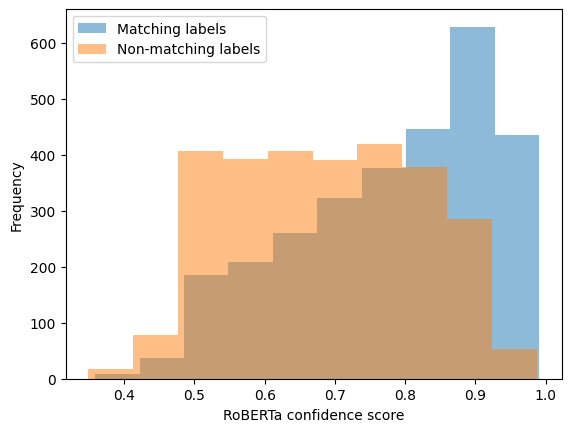

In [39]:
# Plot the distribution of RoBERTa confidence scores for reviews with matching and non-matching labels
import matplotlib.pyplot as plt

plt.hist(selected_data.loc[matching_labels, "roberta_score"], alpha=0.5, label="Matching labels")
plt.hist(selected_data.loc[non_matching_labels, "roberta_score"], alpha=0.5, label="Non-matching labels")
plt.xlabel("RoBERTa confidence score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [44]:
# Save 100 rows with the lowest RoBERTa confidence scores to a new CSV file
low_confidence_rows = selected_data.sort_values("roberta_score").head(100)
low_confidence_rows.drop(columns=["vader_label", "vader_score"], inplace=True)

In [45]:
low_confidence_rows.to_csv('../Data/labelling-round_1.csv', index=False)